# Session 8: Vector Autoregression (VAR)

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Understand the VAR framework for multivariate time series
2. Specify and estimate VAR models
3. Determine optimal lag length using information criteria
4. Compute and interpret Impulse Response Functions (IRFs)
5. Perform variance decomposition analysis
6. Test for Granger causality
7. Generate multivariate forecasts
8. Apply VAR to macroeconomic and financial data

### Prerequisites
- Sessions 1-5: Univariate time series methods
- Understanding of matrix algebra
- Knowledge of multivariate statistics

In [8]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Introduction to VAR Models

### 1.1 Motivation

**Limitations of univariate models**:
- Ignore interdependencies between variables
- Cannot analyze spillovers
- Miss dynamic interactions

**Economic examples**:
- GDP, inflation, interest rates interact
- Stock prices, exchange rates, commodity prices
- Money supply, output, prices

### 1.2 VAR(p) Model

For N-dimensional vector $\mathbf{y}_t$:

$$\mathbf{y}_t = \mathbf{c} + \Phi_1 \mathbf{y}_{t-1} + \Phi_2 \mathbf{y}_{t-2} + \cdots + \Phi_p \mathbf{y}_{t-p} + \mathbf{\epsilon}_t$$

where:
- $\mathbf{y}_t = (y_{1t}, y_{2t}, \ldots, y_{Nt})^\top$ is $N \times 1$
- $\mathbf{c}$ is $N \times 1$ vector of constants
- $\Phi_i$ are $N \times N$ coefficient matrices
- $\mathbf{\epsilon}_t \sim N(\mathbf{0}, \Sigma)$ is white noise

### 1.3 VAR(1) Example

For bivariate system:
$$\begin{pmatrix} y_{1t} \\ y_{2t} \end{pmatrix} = \begin{pmatrix} c_1 \\ c_2 \end{pmatrix} + \begin{pmatrix} \phi_{11} & \phi_{12} \\ \phi_{21} & \phi_{22} \end{pmatrix} \begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \end{pmatrix} + \begin{pmatrix} \epsilon_{1t} \\ \epsilon_{2t} \end{pmatrix}$$

**Expanded**:
$$y_{1t} = c_1 + \phi_{11} y_{1,t-1} + \phi_{12} y_{2,t-1} + \epsilon_{1t}$$
$$y_{2t} = c_2 + \phi_{21} y_{1,t-1} + \phi_{22} y_{2,t-1} + \epsilon_{2t}$$

### 1.4 Key Features

**Each equation**:
- Includes lags of all variables
- Same lag structure across equations
- No contemporaneous variables on RHS

**Advantages**:
- Flexible dynamic structure
- No need to specify which variables are exogenous
- Equation-by-equation OLS is efficient
- Good for forecasting

**Disadvantages**:
- Many parameters: $N^2 p + N$
- Interpretation can be difficult
- All variables must be stationary

In [11]:
# Download macroeconomic/financial data
print("Downloading financial data...")

# Get multiple related time series
tickers = ['^GSPC', '^VIX', '^TNX']  # S&P 500, VIX, 10-Year Treasury
data = yf.download(tickers, start='2010-01-01', end='2024-01-01', progress=False)['Close']
data.columns = ['SP500', 'VIX', 'Treasury_10Y']
data = data.dropna()

# Calculate changes (first differences) to ensure stationarity
# For stock index: returns
# For VIX and rates: changes
var_data = pd.DataFrame()
var_data['SP500_Return'] = data['SP500'].pct_change() * 100
var_data['VIX_Change'] = data['VIX'].diff()
var_data['Rate_Change'] = data['Treasury_10Y'].diff()
var_data = var_data.dropna()

print(f"\nData period: {var_data.index[0].date()} to {var_data.index[-1].date()}")
print(f"Observations: {len(var_data)}")
print(f"Variables: {list(var_data.columns)}")

# Descriptive statistics
print("\nDescriptive Statistics:")
print(var_data.describe().round(4))


Data period: 2010-01-05 to 2023-12-29
Observations: 3519
Variables: ['SP500_Return', 'VIX_Change', 'Rate_Change']

Descriptive Statistics:
       SP500_Return  VIX_Change  Rate_Change
count     3519.0000   3519.0000    3519.0000
mean         0.0470      0.0000      -0.0022
std          1.1037      0.0537       1.8439
min        -11.9841     -0.3220     -17.6400
25%         -0.3884     -0.0310      -0.7500
50%          0.0648     -0.0010      -0.1000
75%          0.5696      0.0320       0.5700
max          9.3828      0.2690      24.8600


In [13]:
# Test for stationarity
def test_stationarity(series, name):
    """
    Test stationarity using ADF test.
    """
    adf_result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{name}:")
    print(f"  ADF Statistic: {adf_result[0]:.4f}")
    print(f"  P-value: {adf_result[1]:.4f}")
    
    if adf_result[1] < 0.05:
        print(f"  ✓ Stationary (reject unit root)")
        return True
    else:
        print(f"  ✗ Non-stationary (cannot reject unit root)")
        return False

print("\n" + "="*60)
print("Stationarity Tests (ADF)")
print("="*60)

stationary = {}
for col in var_data.columns:
    stationary[col] = test_stationarity(var_data[col], col)

if all(stationary.values()):
    print("\n✓ All series are stationary → Proceed with VAR")
else:
    print("\n⚠ Some series non-stationary → May need VECM (Session 9)")


Stationarity Tests (ADF)

SP500_Return:
  ADF Statistic: -13.0326
  P-value: 0.0000
  ✓ Stationary (reject unit root)

VIX_Change:
  ADF Statistic: -11.2189
  P-value: 0.0000
  ✓ Stationary (reject unit root)

Rate_Change:
  ADF Statistic: -14.2376
  P-value: 0.0000
  ✓ Stationary (reject unit root)

✓ All series are stationary → Proceed with VAR


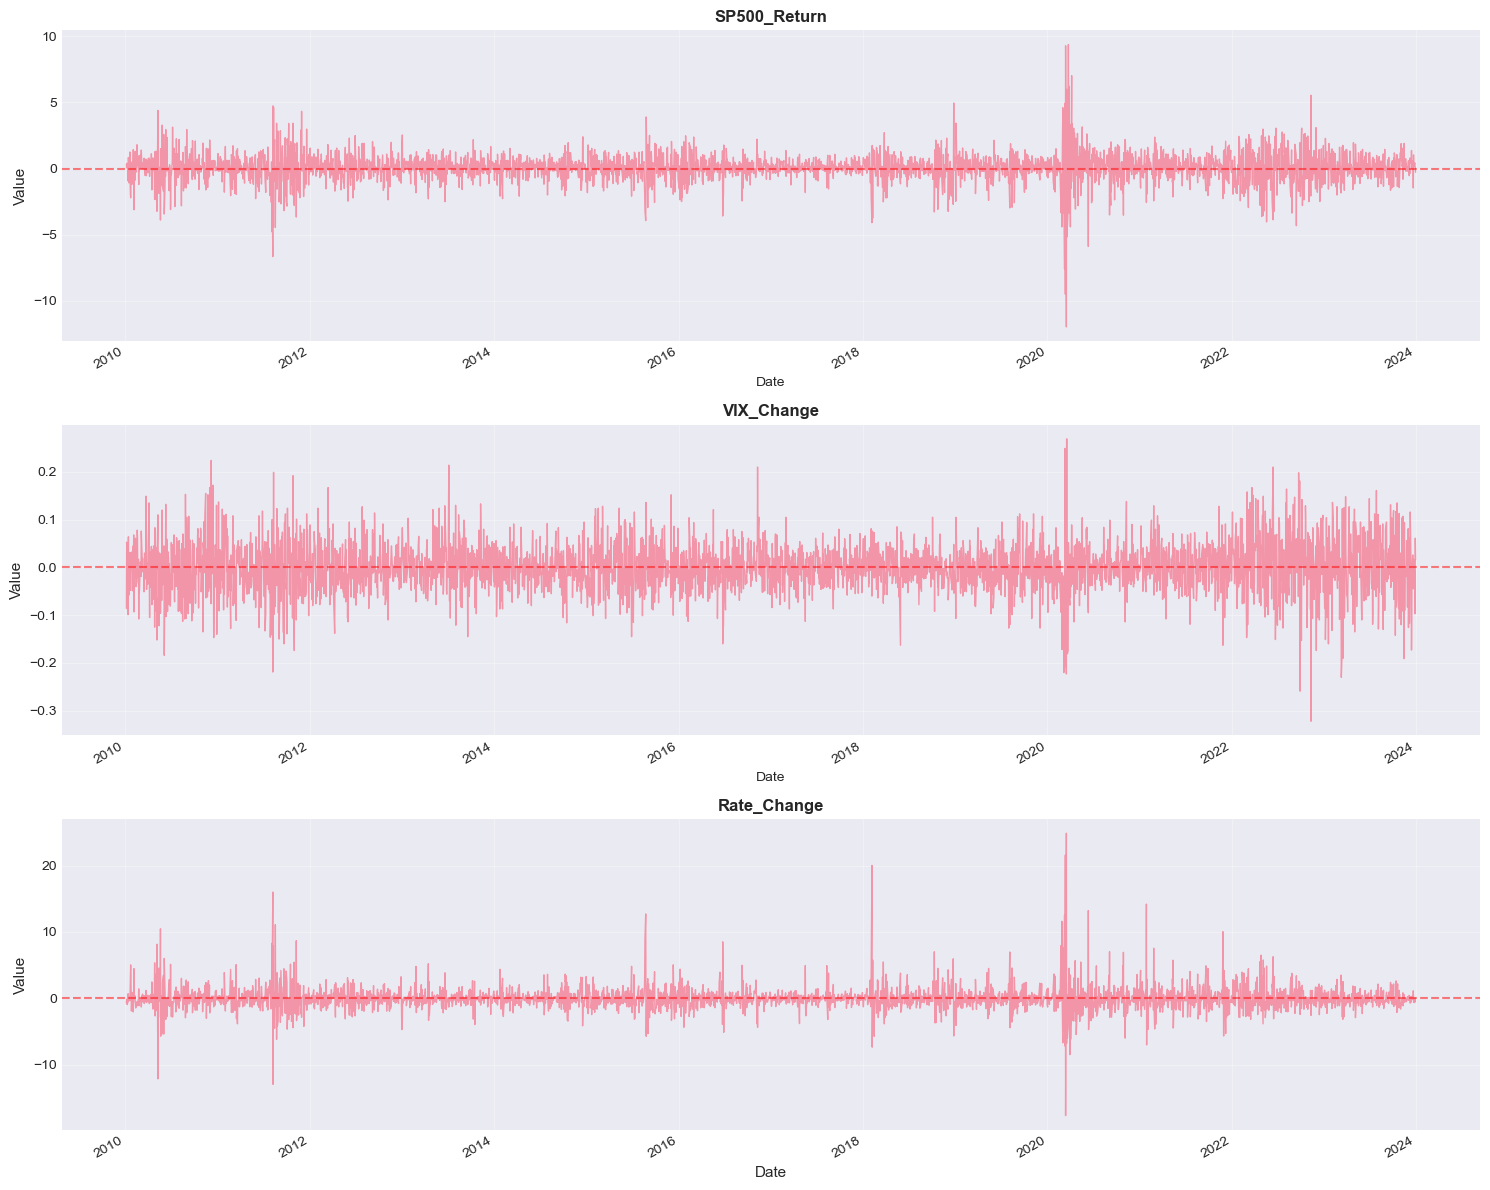


Correlation Matrix:
              SP500_Return  VIX_Change  Rate_Change
SP500_Return        1.0000      0.2803      -0.8047
VIX_Change          0.2803      1.0000      -0.2561
Rate_Change        -0.8047     -0.2561       1.0000


In [15]:
# Visualize the data
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, col in enumerate(var_data.columns):
    var_data[col].plot(ax=axes[idx], linewidth=1, alpha=0.7)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[idx].set_title(col, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    
    if idx == 2:
        axes[idx].set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

# Correlation matrix
print("\nCorrelation Matrix:")
print(var_data.corr().round(4))

## 2. VAR Model Specification and Estimation

### 2.1 Lag Length Selection

Choose $p$ using information criteria:

**AIC**: $\text{AIC}(p) = \log|\hat{\Sigma}(p)| + \frac{2}{T}pN^2$

**BIC**: $\text{BIC}(p) = \log|\hat{\Sigma}(p)| + \frac{\log T}{T}pN^2$

**HQC**: $\text{HQC}(p) = \log|\hat{\Sigma}(p)| + \frac{2\log\log T}{T}pN^2$

where $\hat{\Sigma}(p)$ is estimated covariance matrix.

**General principle**:
- BIC: More parsimonious (larger penalty)
- AIC: More flexible (smaller penalty)
- Try $p = 1, 2, \ldots, p_{\max}$ and select minimum

### 2.2 Estimation

**OLS equation by equation**:
- Efficient if $\Sigma$ is diagonal
- Consistent even if not
- Simple to implement

**ML estimation**:
- More efficient
- Equivalent to OLS if no restrictions

### 2.3 Stability Condition

VAR is stable if eigenvalues of companion matrix are inside unit circle.

**Companion form** for VAR(p):
$$\mathbf{Y}_t = \mathbf{F} \mathbf{Y}_{t-1} + \mathbf{E}_t$$

where $\mathbf{F}$ is $Np \times Np$ companion matrix.

Stability: $|\lambda_i| < 1$ for all eigenvalues $\lambda_i$ of $\mathbf{F}$.

In [18]:
# Lag length selection
print("\n" + "="*60)
print("VAR Lag Length Selection")
print("="*60)

# Create VAR model object
model = VAR(var_data)

# Test different lag lengths
max_lags = 10
lag_order = model.select_order(maxlags=max_lags)

print("\nInformation Criteria:")
print(lag_order.summary())

# Select based on BIC (more conservative)
selected_lag = lag_order.bic
print(f"\nSelected lag order (BIC): {selected_lag}")

# Also show AIC selection
aic_lag = lag_order.aic
print(f"AIC suggests: {aic_lag}")
print(f"HQC suggests: {lag_order.hqic}")


VAR Lag Length Selection

Information Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -5.551      -5.546    0.003882      -5.549
1       -5.577      -5.556    0.003782      -5.570
2       -5.594     -5.557*    0.003722      -5.580
3       -5.596      -5.544    0.003711      -5.578
4       -5.621      -5.552    0.003621      -5.596
5       -5.624      -5.540    0.003609      -5.594
6       -5.632      -5.532    0.003580      -5.597
7       -5.655      -5.540    0.003498      -5.614
8       -5.658      -5.527    0.003488      -5.611
9       -5.672      -5.525    0.003441     -5.619*
10     -5.675*      -5.511   0.003432*      -5.616
--------------------------------------------------

Selected lag order (BIC): 2
AIC suggests: 10
HQC suggests: 9


In [20]:
# Estimate VAR model
print("\n" + "="*60)
print(f"Estimating VAR({selected_lag}) Model")
print("="*60)

# Fit the model
var_fitted = model.fit(selected_lag)

# Display summary
print(var_fitted.summary())


Estimating VAR(2) Model
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Jan, 2026
Time:                     12:37:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.55979
Nobs:                     3517.00    HQIC:                  -5.58347
Log likelihood:          -5108.60    FPE:                 0.00371045
AIC:                     -5.59660    Det(Omega_mle):      0.00368838
--------------------------------------------------------------------
Results for equation SP500_Return
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.050877         0.018525            2.746           0.006
L1.SP500_Return        -0.079249         0.028387           -2.792           0.005
L1.VIX_Change       


Model Stability Check

Maximum eigenvalue modulus: 0.1533
✓ VAR model is stable (all roots inside unit circle)


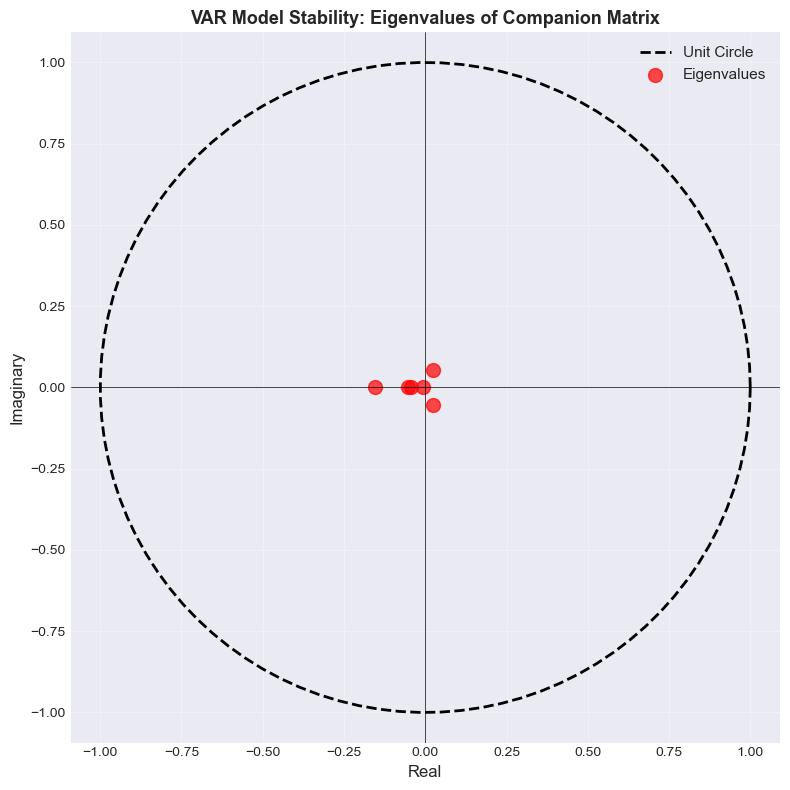

In [30]:
# Check model stability
print("\n" + "="*60)
print("Model Stability Check")
print("="*60)

# Get eigenvalues of companion matrix
eigenvalues = np.linalg.eigvals(var_fitted.coefs)
max_eigenvalue = np.abs(eigenvalues).max()

print(f"\nMaximum eigenvalue modulus: {max_eigenvalue:.4f}")

if max_eigenvalue < 1:
    print("✓ VAR model is stable (all roots inside unit circle)")
else:
    print("✗ VAR model is unstable (some roots outside unit circle)")

# Plot roots
fig, ax = plt.subplots(figsize=(8, 8))

# Unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=2, label='Unit Circle')

# Eigenvalues
ax.scatter(eigenvalues.real, eigenvalues.imag, s=100, c='red', 
          marker='o', alpha=0.7, label='Eigenvalues')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Real', fontsize=12)
ax.set_ylabel('Imaginary', fontsize=12)
ax.set_title('VAR Model Stability: Eigenvalues of Companion Matrix', 
            fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

In [16]:
# Residual diagnostics
print("\n" + "="*60)
print("Residual Diagnostics")
print("="*60)

# Get residuals
residuals = var_fitted.resid

# Test for serial correlation
print("\nPortmanteau Test (Serial Correlation):")
portmanteau = var_fitted.test_whiteness(nlags=10, signif=0.05)
print(portmanteau.summary())

# Test for normality
print("\nNormality Test (Jarque-Bera):")
normality = var_fitted.test_normality()
print(normality.summary())

# Residual correlation matrix
print("\nResidual Correlation Matrix:")
print(residuals.corr().round(4))


Residual Diagnostics

Portmanteau Test (Serial Correlation):
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         404.0          92.81   0.000 72
----------------------------------------

Normality Test (Jarque-Bera):
normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     1.516e+05          12.59   0.000  6
----------------------------------------

Residual Correlation Matrix:
              SP500_Return  VIX_Change  Rate_Change
SP500_Return        1.0000      0.2759      -0.8043
VIX_Change          0.2759      1.0000      -0.2519
Rate_Change        -0.8043     -0.2519       1.0000


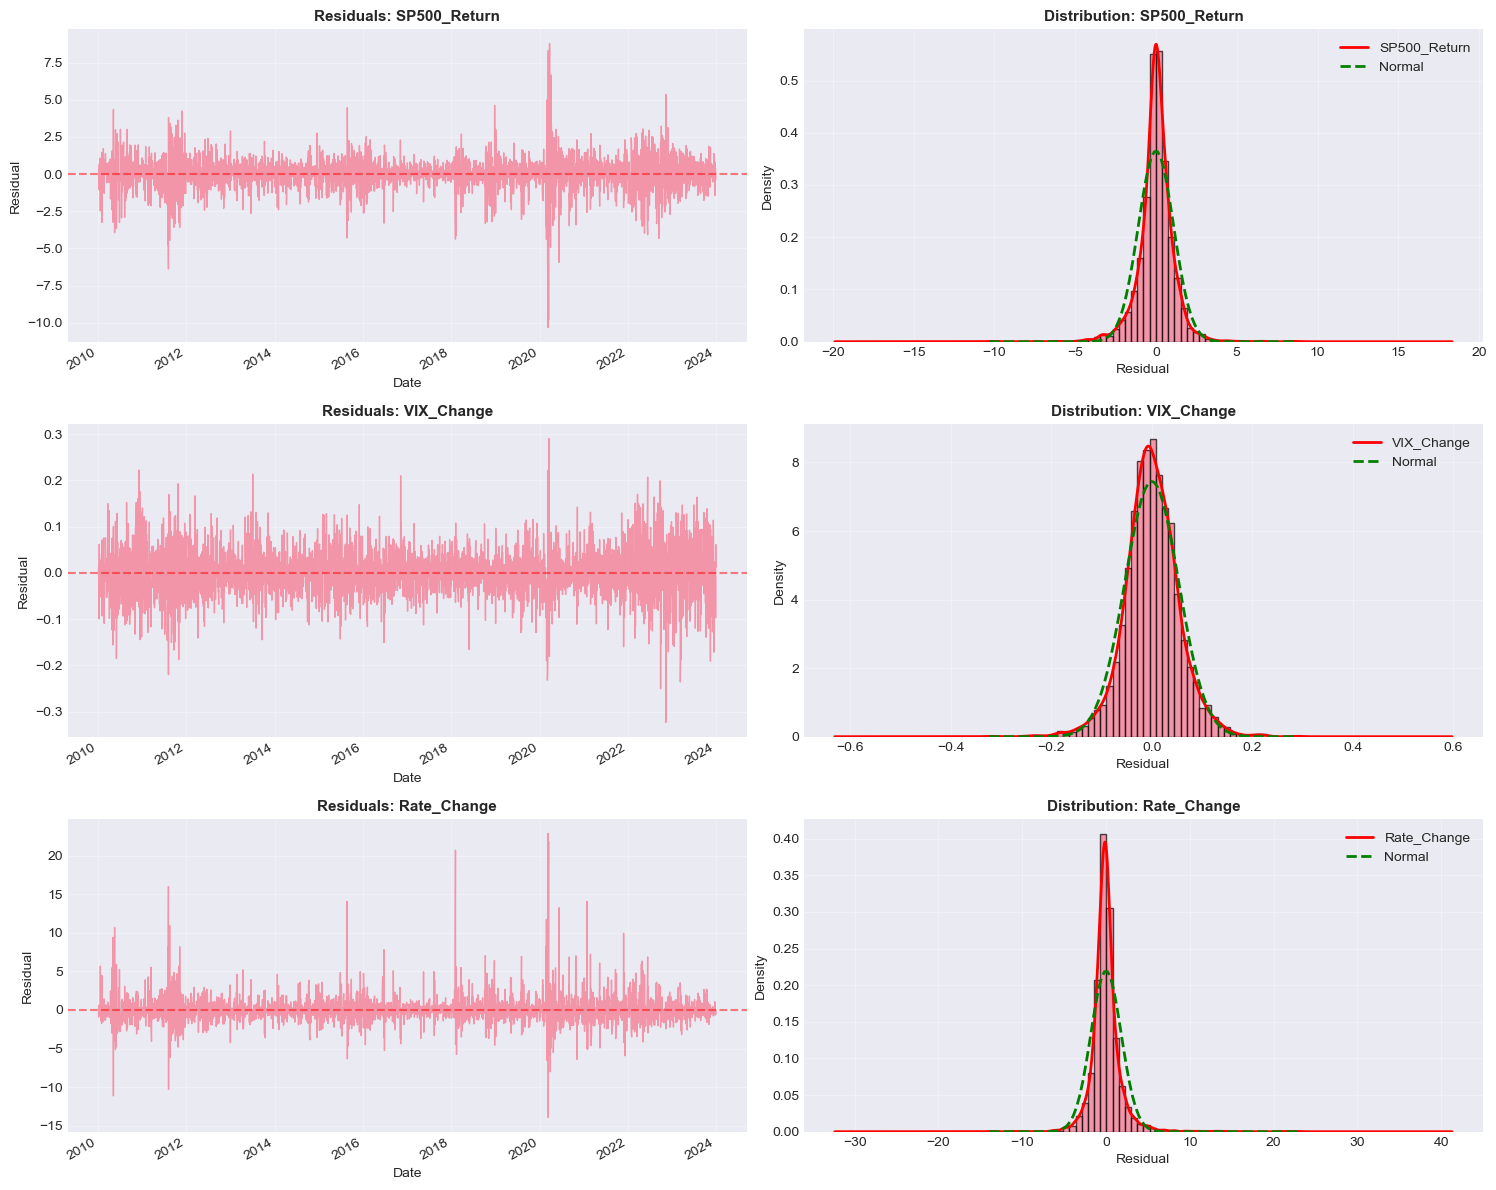

In [18]:
# Visualize residuals
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for idx, col in enumerate(residuals.columns):
    # Time series plot
    residuals[col].plot(ax=axes[idx, 0], linewidth=1, alpha=0.7)
    axes[idx, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[idx, 0].set_title(f'Residuals: {col}', fontsize=11, fontweight='bold')
    axes[idx, 0].set_ylabel('Residual')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Histogram
    residuals[col].hist(ax=axes[idx, 1], bins=50, density=True, 
                        alpha=0.7, edgecolor='black')
    residuals[col].plot.kde(ax=axes[idx, 1], color='red', linewidth=2)
    
    # Overlay normal distribution
    x = np.linspace(residuals[col].min(), residuals[col].max(), 100)
    axes[idx, 1].plot(x, stats.norm.pdf(x, residuals[col].mean(), 
                                        residuals[col].std()),
                     'g--', linewidth=2, label='Normal')
    
    axes[idx, 1].set_title(f'Distribution: {col}', fontsize=11, fontweight='bold')
    axes[idx, 1].set_xlabel('Residual')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Granger Causality

### 3.1 Concept

**Definition**: Variable $x$ Granger-causes $y$ if past values of $x$ help predict $y$ beyond what past values of $y$ alone can predict.

**NOT the same as true causality**:
- Statistical relationship only
- Predictive causality
- Direction matters: $x \to y$ vs $y \to x$

### 3.2 Testing in VAR

Consider VAR(p):
$$y_t = c + \sum_{i=1}^p \phi_i y_{t-i} + \sum_{i=1}^p \beta_i x_{t-i} + \epsilon_t$$

**$x$ does NOT Granger-cause $y$**: $H_0: \beta_1 = \beta_2 = \cdots = \beta_p = 0$

**Test**: F-test for joint significance.

### 3.3 Interpretation

**Unidirectional**: $x \to y$ but not $y \to x$

**Bidirectional**: $x \leftrightarrow y$ (feedback)

**No causality**: Neither direction significant

**Example applications**:
- Does money supply cause output?
- Do stock returns predict economic activity?
- Exchange rate and trade balance

In [21]:
# Granger causality tests
print("\n" + "="*60)
print("Granger Causality Tests")
print("="*60)

# Test all pairwise causalities
variables = var_data.columns.tolist()
max_lag = selected_lag

print(f"\nTesting at lag order: {max_lag}")
print("\nNull Hypothesis: [Variable 1] does NOT Granger-cause [Variable 2]\n")

causality_matrix = pd.DataFrame(index=variables, columns=variables)

for caused in variables:
    for causing in variables:
        if caused != causing:
            # Test if 'causing' Granger-causes 'caused'
            test_data = var_data[[caused, causing]]
            try:
                gc_test = grangercausalitytests(test_data, max_lag, verbose=False)
                
                # Get p-value for F-test at selected lag
                p_value = gc_test[max_lag][0]['ssr_ftest'][1]
                causality_matrix.loc[causing, caused] = p_value
                
                result = "YES" if p_value < 0.05 else "NO"
                print(f"{causing:20s} → {caused:20s}: p-value = {p_value:.4f} ({result})")
            except:
                causality_matrix.loc[causing, caused] = np.nan
                print(f"{causing:20s} → {caused:20s}: Test failed")
        else:
            causality_matrix.loc[causing, caused] = np.nan

# Convert to numeric
causality_matrix = causality_matrix.astype(float)

print("\n" + "="*60)
print("Summary: P-values Matrix")
print("="*60)
print("\nRows → Columns (causing → caused)")
print(causality_matrix.round(4))
print("\nNote: Values < 0.05 indicate significant Granger causality")


Granger Causality Tests

Testing at lag order: 2

Null Hypothesis: [Variable 1] does NOT Granger-cause [Variable 2]

VIX_Change           → SP500_Return        : p-value = 0.5512 (NO)
Rate_Change          → SP500_Return        : p-value = 0.0035 (YES)
SP500_Return         → VIX_Change          : p-value = 0.0422 (YES)
Rate_Change          → VIX_Change          : p-value = 0.0040 (YES)
SP500_Return         → Rate_Change         : p-value = 0.0288 (YES)
VIX_Change           → Rate_Change         : p-value = 0.4428 (NO)

Summary: P-values Matrix

Rows → Columns (causing → caused)
              SP500_Return  VIX_Change  Rate_Change
SP500_Return           NaN      0.0422       0.0288
VIX_Change          0.5512         NaN       0.4428
Rate_Change         0.0035      0.0040          NaN

Note: Values < 0.05 indicate significant Granger causality


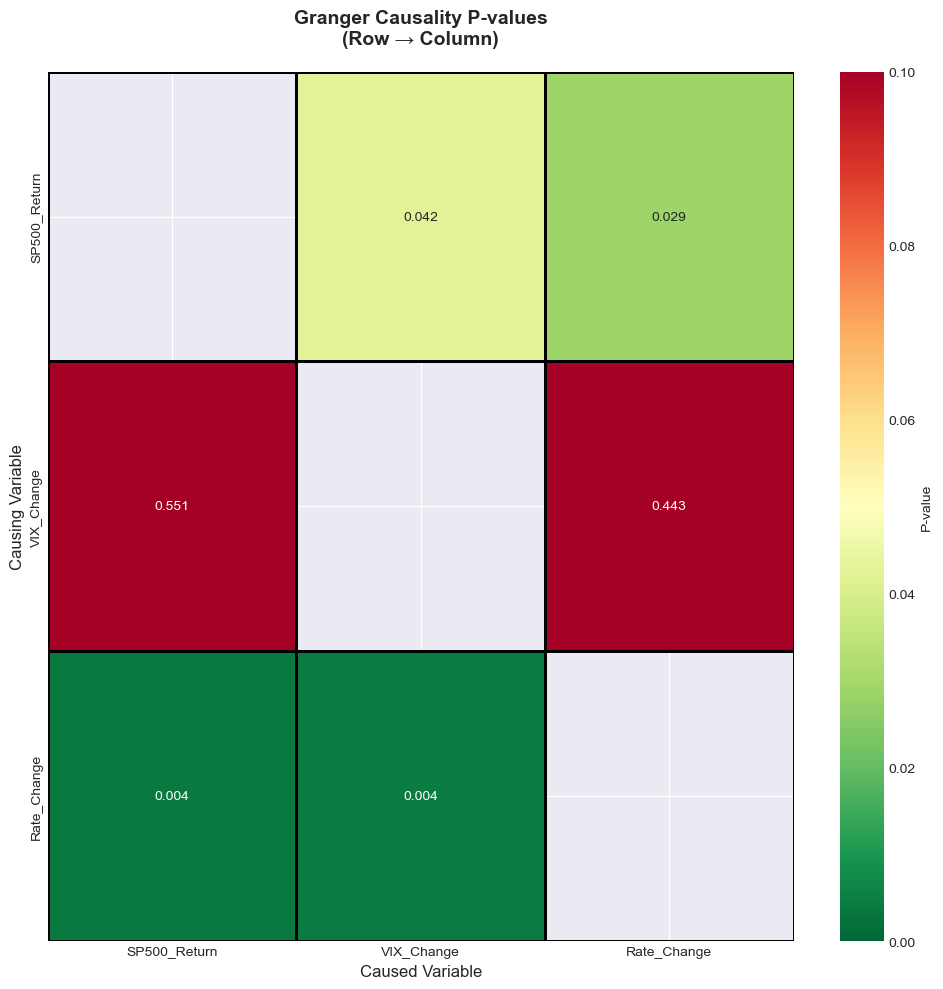


Interpretation Guide:
• Green cells (p < 0.05): Significant Granger causality
• Red cells (p > 0.05): No Granger causality
• Diagonal: Self-causality (not tested)


In [23]:
# Visualize causality network
fig, ax = plt.subplots(figsize=(10, 10))

# Create heatmap of p-values
mask = np.eye(len(variables), dtype=bool)
sns.heatmap(causality_matrix, annot=True, fmt=".3f", cmap="RdYlGn_r",
           vmin=0, vmax=0.1, center=0.05, mask=mask,
           cbar_kws={'label': 'P-value'}, ax=ax,
           linewidths=1, linecolor='black')

ax.set_title('Granger Causality P-values\n(Row → Column)', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Caused Variable', fontsize=12)
ax.set_ylabel('Causing Variable', fontsize=12)

plt.tight_layout()
plt.show()

print("\nInterpretation Guide:")
print("• Green cells (p < 0.05): Significant Granger causality")
print("• Red cells (p > 0.05): No Granger causality")
print("• Diagonal: Self-causality (not tested)")

## 4. Impulse Response Functions (IRFs)

### 4.1 Concept

**IRF**: Response of variable $i$ to a one-time shock in variable $j$.

**Moving Average Representation**:
$$\mathbf{y}_t = \boldsymbol{\mu} + \sum_{i=0}^\infty \Psi_i \mathbf{\epsilon}_{t-i}$$

where $\Psi_i$ are MA coefficient matrices.

**IRF at horizon $h$**:
$$\text{IRF}(h) = \frac{\partial y_{i,t+h}}{\partial \epsilon_{jt}} = [\Psi_h]_{ij}$$

### 4.2 Orthogonalization

**Problem**: Shocks $\mathbf{\epsilon}_t$ may be correlated.

**Cholesky decomposition**: $\Sigma = PP^\top$

Orthogonalized shocks: $\mathbf{u}_t = P^{-1}\mathbf{\epsilon}_t$

**Ordering matters**: Variable ordered first has contemporaneous effect on all others.

### 4.3 Interpretation

- **Initial impact** (h=0): Contemporaneous effect
- **Peak response**: Maximum effect and timing
- **Persistence**: How long shock affects system
- **Sign**: Positive or negative response

### 4.4 Confidence Intervals

Calculated via:
- **Asymptotic approximation**
- **Bootstrap**: Monte Carlo or residual bootstrap

In [26]:
# Compute Impulse Response Functions
print("\n" + "="*60)
print("Impulse Response Functions")
print("="*60)

# Calculate IRFs
irf = var_fitted.irf(periods=20)

print("\nOrthogonalized IRFs (Cholesky ordering)")
print(f"Variable ordering: {list(var_data.columns)}")
print("\nNote: Ordering affects contemporaneous relationships")


Impulse Response Functions

Orthogonalized IRFs (Cholesky ordering)
Variable ordering: ['SP500_Return', 'VIX_Change', 'Rate_Change']

Note: Ordering affects contemporaneous relationships


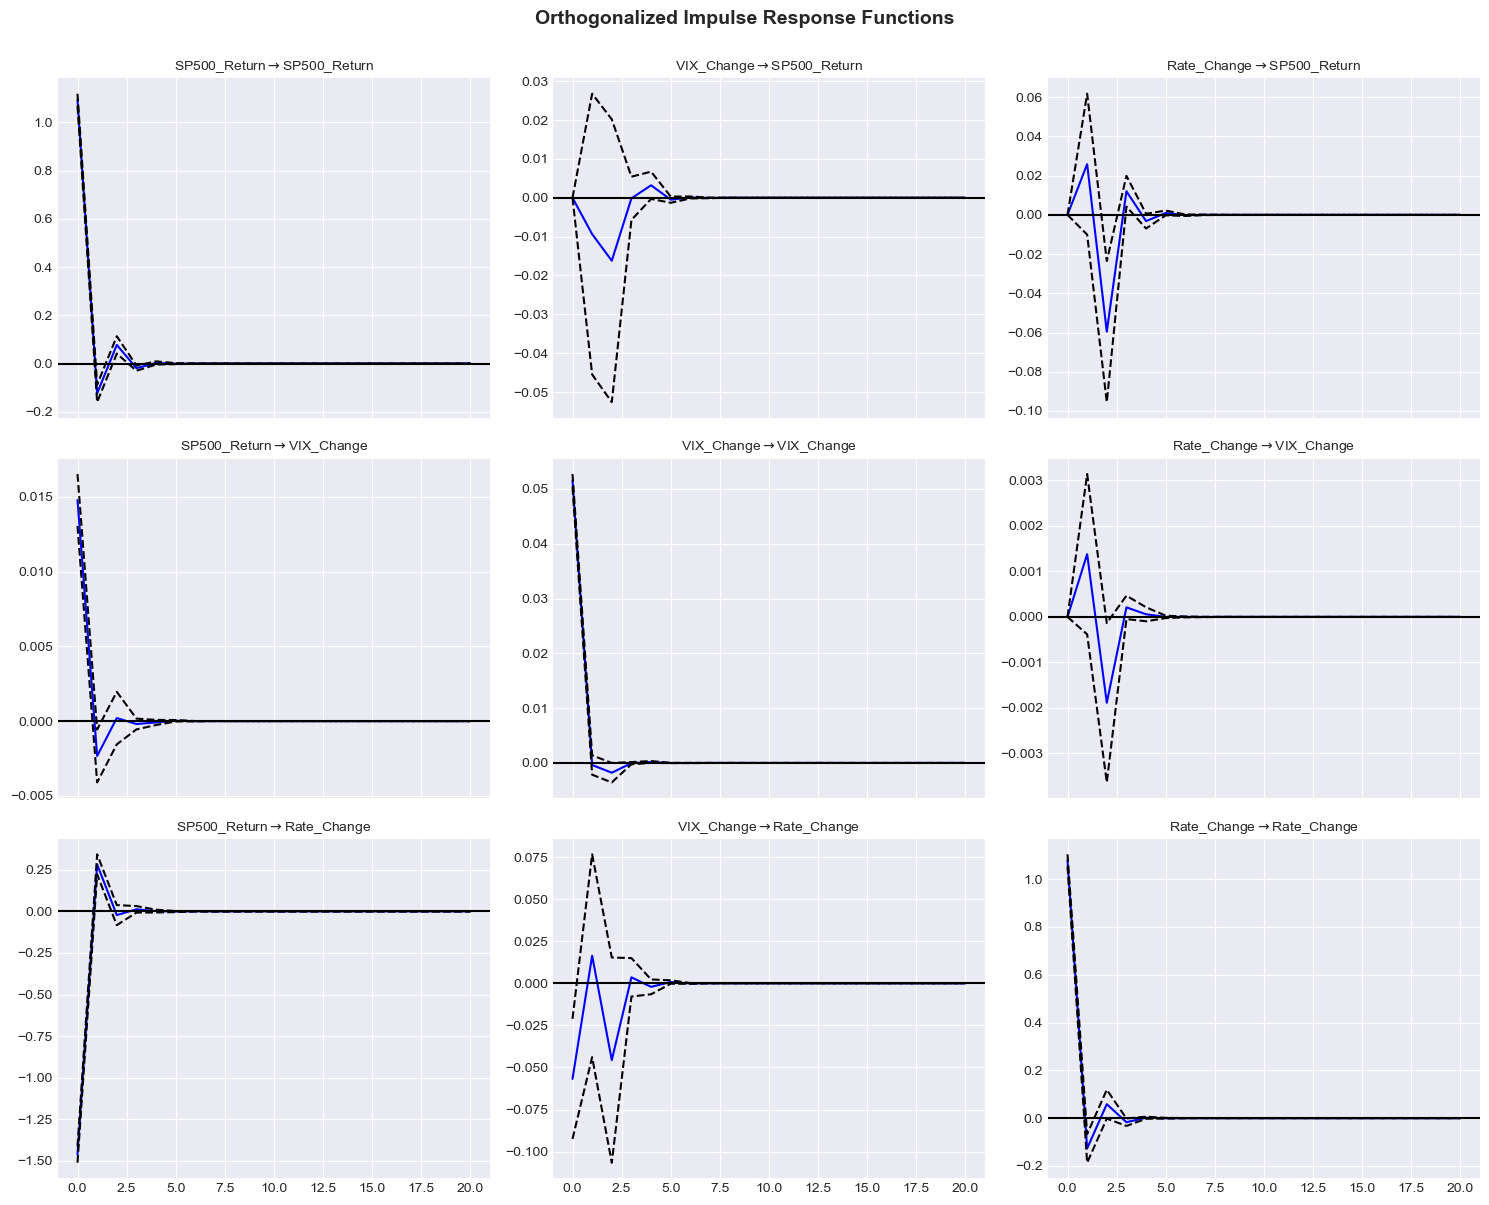


How to read IRF plots:
• Each subplot: Response of [row variable] to shock in [column variable]
• X-axis: Periods after shock
• Y-axis: Size of response
• Blue line: Point estimate
• Shaded area: Confidence interval (95%)


In [28]:
# Plot IRFs
fig = irf.plot(orth=True, impulse=None, response=None, 
              figsize=(15, 12), subplot_params={'fontsize': 10})

plt.suptitle('Orthogonalized Impulse Response Functions', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nHow to read IRF plots:")
print("• Each subplot: Response of [row variable] to shock in [column variable]")
print("• X-axis: Periods after shock")
print("• Y-axis: Size of response")
print("• Blue line: Point estimate")
print("• Shaded area: Confidence interval (95%)")

TypeError: BaseIRAnalysis.plot() got an unexpected keyword argument 'ax'

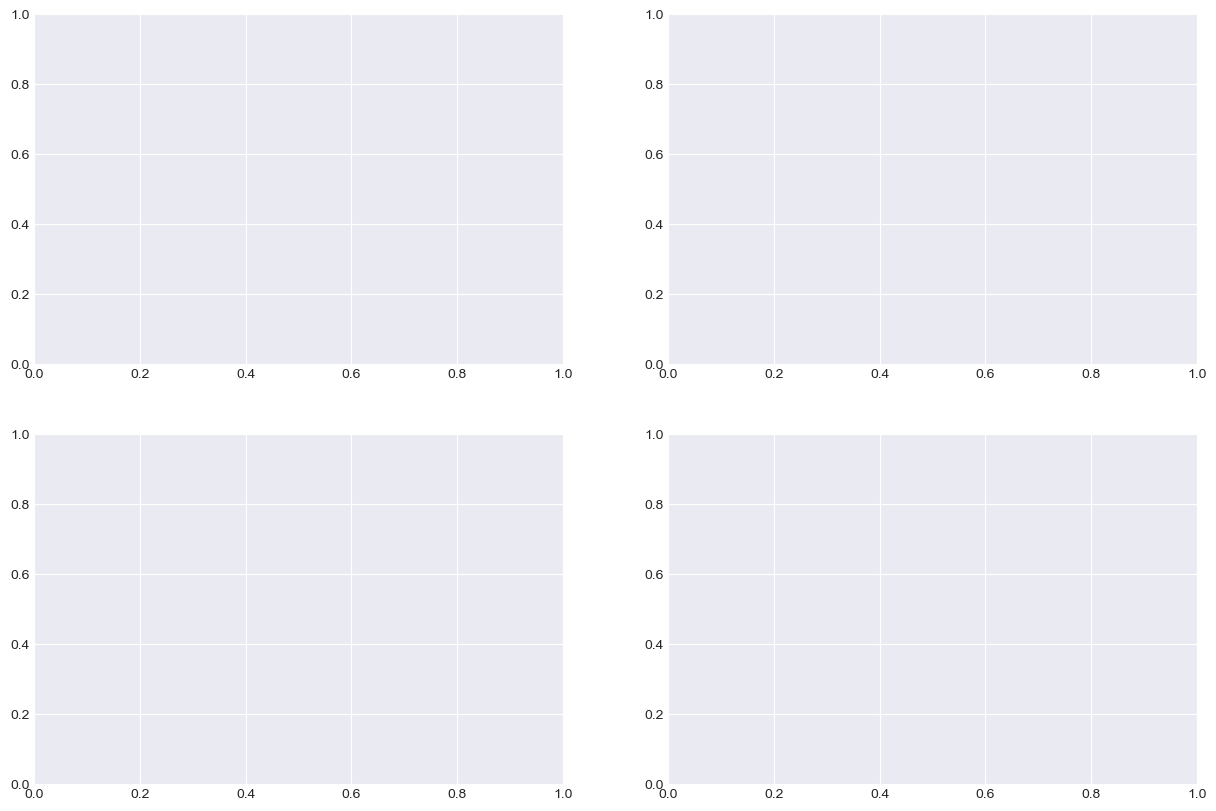

In [36]:
# Plot specific IRFs of interest
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define interesting shock-response pairs
pairs = [
    ('VIX_Change', 'SP500_Return', 0, 0),
    ('SP500_Return', 'VIX_Change', 0, 1),
    ('Rate_Change', 'SP500_Return', 1, 0),
    ('SP500_Return', 'Rate_Change', 1, 1)
]

for shock, response, i, j in pairs:
    irf.plot(orth=True, impulse=shock, response=response, 
            ax=axes[i, j], signif=0.05)
    axes[i, j].set_title(f'Response of {response}\nto shock in {shock}',
                        fontsize=11, fontweight='bold')
    axes[i, j].set_xlabel('Periods', fontsize=10)
    axes[i, j].set_ylabel('Response', fontsize=10)
    axes[i, j].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[i, j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights from IRFs:")
print("• VIX shock → negative S&P 500 response (risk aversion)")
print("• S&P 500 shock → VIX response (volatility clustering)")
print("• Rate changes affect equity returns")
print("• Persistence varies across shock-response pairs")

## 5. Forecast Error Variance Decomposition (FEVD)

### 5.1 Concept

**Question**: What fraction of forecast error variance of variable $i$ at horizon $h$ is due to shocks in variable $j$?

**h-step ahead forecast error**:
$$\mathbf{y}_{t+h} - \mathbf{y}_{t+h|t} = \sum_{i=0}^{h-1} \Psi_i \mathbf{\epsilon}_{t+h-i}$$

**Variance of forecast error**:
$$\text{MSE}(h) = \sum_{i=0}^{h-1} \Psi_i \Sigma \Psi_i^\top$$

### 5.2 Decomposition

Contribution of shock $j$ to variance of variable $i$:
$$\theta_{ij}(h) = \frac{\sum_{k=0}^{h-1} (\mathbf{e}_i^\top \Psi_k \mathbf{P} \mathbf{e}_j)^2}{\mathbf{e}_i^\top \text{MSE}(h) \mathbf{e}_i}$$

where $\mathbf{e}_i$ is $i$-th unit vector, $P$ is Cholesky factor.

### 5.3 Properties

- $\sum_{j=1}^N \theta_{ij}(h) = 1$ for each $i, h$
- Depends on ordering (like IRFs)
- Short horizon: Mainly own shocks
- Long horizon: Spillovers more important

### 5.4 Interpretation

**Exogenous variable**: Explains mostly its own variance

**Endogenous variable**: Variance explained by other variables

**Common drivers**: High cross-contributions

In [38]:
# Compute Forecast Error Variance Decomposition
print("\n" + "="*60)
print("Forecast Error Variance Decomposition")
print("="*60)

# Calculate FEVD
fevd = var_fitted.fevd(periods=20)

# Display FEVD for each variable at selected horizons
horizons = [1, 5, 10, 20]

for var in var_data.columns:
    print(f"\n{'='*60}")
    print(f"Variance Decomposition of: {var}")
    print(f"{'='*60}")
    
    for h in horizons:
        print(f"\nHorizon {h}:")
        decomp = fevd.decomp[h-1]
        var_idx = list(var_data.columns).index(var)
        
        for j, shock_var in enumerate(var_data.columns):
            contribution = decomp[var_idx, j] * 100
            print(f"  {shock_var:25s}: {contribution:6.2f}%")


Forecast Error Variance Decomposition

Variance Decomposition of: SP500_Return

Horizon 1:
  SP500_Return             : 100.00%
  VIX_Change               :   0.00%
  Rate_Change              :   0.00%

Horizon 5:


IndexError: index 4 is out of bounds for axis 0 with size 3

In [ ]:
# Plot FEVD
fevd.plot(figsize=(15, 12))
plt.suptitle('Forecast Error Variance Decomposition', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nHow to read FEVD plots:")
print("• Each panel: Variance decomposition of one variable")
print("• X-axis: Forecast horizon")
print("• Y-axis: Proportion of variance (0 to 1)")
print("• Colors: Different shock sources")
print("• Stacked areas: Sum to 100%")

In [ ]:
# Create custom FEVD visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

periods = np.arange(1, 21)
colors = plt.cm.Set2(np.linspace(0, 1, len(var_data.columns)))

for idx, var in enumerate(var_data.columns):
    var_idx = list(var_data.columns).index(var)
    
    # Get variance contributions over time
    contributions = np.zeros((20, len(var_data.columns)))
    for h in range(20):
        contributions[h, :] = fevd.decomp[h][var_idx, :]
    
    # Create stacked area plot
    axes[idx].stackplot(periods, contributions.T, 
                       labels=var_data.columns, alpha=0.8,
                       colors=colors)
    
    axes[idx].set_title(f'FEVD: {var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Forecast Horizon', fontsize=11)
    axes[idx].set_ylabel('Proportion of Variance', fontsize=11)
    axes[idx].set_ylim(0, 1)
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFEVD Insights:")
print("• Short horizon: Own shocks dominate")
print("• Medium horizon: Spillovers become important")
print("• Long horizon: Reveals interdependencies")
print("• Identify leading vs lagging variables")

## 6. Forecasting with VAR

### 6.1 Point Forecasts

**h-step ahead forecast**:
$$\hat{\mathbf{y}}_{T+h|T} = \mathbf{c} + \Phi_1 \hat{\mathbf{y}}_{T+h-1|T} + \cdots + \Phi_p \hat{\mathbf{y}}_{T+h-p|T}$$

with $\hat{\mathbf{y}}_{T+j|T} = \mathbf{y}_{T+j}$ for $j \leq 0$.

### 6.2 Forecast Error Covariance

$$\text{Var}(\mathbf{y}_{T+h} - \hat{\mathbf{y}}_{T+h|T}) = \sum_{i=0}^{h-1} \Psi_i \Sigma \Psi_i^\top$$

### 6.3 Prediction Intervals

For each variable:
$$\hat{y}_{i,T+h|T} \pm z_{\alpha/2} \sqrt{[\text{MSE}(h)]_{ii}}$$

### 6.4 Advantages

- Uses information from all variables
- Captures dynamic interactions
- Often outperforms univariate models
- Internally consistent forecasts

In [ ]:
# Generate forecasts
print("\n" + "="*60)
print("VAR Forecasting")
print("="*60)

# Split data into train and test
train_size = int(len(var_data) * 0.95)
train_data = var_data[:train_size]
test_data = var_data[train_size:]

print(f"\nTraining sample: {len(train_data)} observations")
print(f"Test sample: {len(test_data)} observations")

# Fit model on training data
model_train = VAR(train_data)
var_train = model_train.fit(selected_lag)

# Generate forecasts
forecast_steps = len(test_data)
forecast = var_train.forecast(train_data.values[-selected_lag:], steps=forecast_steps)

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast, 
                          index=test_data.index, 
                          columns=var_data.columns)

# Calculate forecast errors
errors = test_data - forecast_df

# Calculate accuracy metrics
print("\nForecast Accuracy Metrics:")
print("="*60)

for col in var_data.columns:
    mae = np.abs(errors[col]).mean()
    rmse = np.sqrt((errors[col]**2).mean())
    
    print(f"\n{col}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

In [ ]:
# Visualize forecasts
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, col in enumerate(var_data.columns):
    # Plot historical data
    train_data[col].iloc[-100:].plot(ax=axes[idx], linewidth=1.5, 
                                     label='Training', color='blue', alpha=0.7)
    
    # Plot test data (actual)
    test_data[col].plot(ax=axes[idx], linewidth=2, 
                       label='Actual', color='black')
    
    # Plot forecasts
    forecast_df[col].plot(ax=axes[idx], linewidth=2, 
                         label='Forecast', color='red', style='--')
    
    # Add vertical line at forecast origin
    axes[idx].axvline(x=train_data.index[-1], color='green', 
                     linestyle=':', alpha=0.7, linewidth=2)
    
    axes[idx].set_title(f'VAR Forecast: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value', fontsize=11)
    axes[idx].legend(loc='best', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    if idx == 2:
        axes[idx].set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# Plot forecast errors
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for idx, col in enumerate(var_data.columns):
    errors[col].plot(ax=axes[idx], linewidth=1.5, color='purple', alpha=0.7)
    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[idx].fill_between(errors.index, 0, errors[col], 
                          where=(errors[col] > 0),
                          color='green', alpha=0.3, label='Over-prediction')
    axes[idx].fill_between(errors.index, 0, errors[col],
                          where=(errors[col] <= 0),
                          color='red', alpha=0.3, label='Under-prediction')
    
    axes[idx].set_title(f'Forecast Errors: {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Error', fontsize=11)
    axes[idx].legend(loc='best', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    if idx == 2:
        axes[idx].set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

print("\nForecast Insights:")
print("• VAR uses all variables for each forecast")
print("• Captures cross-variable dynamics")
print("• Errors reveal systematic patterns")
print("• Compare with univariate forecasts")

## 7. Summary and Best Practices

### 7.1 VAR Modeling Workflow

**Step 1: Data Preparation**
- Ensure all variables stationary (ADF test)
- Transform if needed (differences, logs)
- Check for structural breaks
- Align time series frequencies

**Step 2: Specification**
- Select lag length (AIC, BIC, HQC)
- Choose variable ordering for IRFs
- Decide on deterministic terms (constant, trend)

**Step 3: Estimation**
- Fit VAR model
- Check stability (eigenvalues)
- Verify no serial correlation in residuals
- Test normality if needed

**Step 4: Analysis**
- Granger causality tests
- Impulse response functions
- Variance decomposition
- Economic interpretation

**Step 5: Forecasting**
- Generate point forecasts
- Calculate prediction intervals
- Evaluate out-of-sample performance
- Compare with benchmarks

### 7.2 Common Applications

| Application | Variables | Key Analysis |
|-------------|-----------|-------------|
| Monetary policy | GDP, Inflation, Interest rate | IRFs to policy shock |
| Financial contagion | Stock indices across countries | FEVD, Granger causality |
| Exchange rates | FX rates, interest differentials | Forecasting |
| Asset pricing | Returns, factors | Variance decomposition |
| Macroeconomic forecasting | Output, prices, employment | Multi-step forecasts |

### 7.3 Key Takeaways

**VAR Models**:
- Flexible framework for multivariate dynamics
- Each variable function of its own lags and others
- No need to specify exogeneity
- Atheoretical but useful for forecasting

**Granger Causality**:
- Tests predictive relationships
- Not true causality
- Sensitive to lag length and specification
- Bidirectional feedback common

**IRFs and FEVD**:
- Show dynamic responses to shocks
- Ordering matters (use theory or robustness checks)
- Variance decomposition reveals importance
- Essential for policy analysis

**Forecasting**:
- Often outperforms univariate models
- Uses cross-variable information
- Produces consistent forecasts
- Uncertainty grows with horizon

### 7.4 Limitations

- **Many parameters**: $N^2 p + N$ coefficients
- **Overfitting risk**: With high N or p
- **Requires stationarity**: Use VECM if cointegrated
- **Ordering dependence**: IRFs sensitive to ordering
- **Short samples**: Need sufficient observations

### 7.5 Extensions

- **SVAR**: Structural VAR with theory-based restrictions
- **VECM**: For cointegrated variables (Session 9)
- **TVP-VAR**: Time-varying parameters (Sessions 10-11)
- **BVAR**: Bayesian VAR with shrinkage
- **Factor-augmented VAR**: Large datasets

### 7.6 Next Session Preview

In **Session 9**, we will cover:
- Cointegration concept and testing
- Engle-Granger two-step method
- Johansen procedure
- Vector Error Correction Models (VECM)
- Long-run vs short-run dynamics

## 8. Exercises

### Exercise 1: VAR Specification
Download quarterly data for GDP, inflation, and unemployment:
1. Test each series for stationarity
2. Transform as needed (differences, logs)
3. Select optimal lag length
4. Estimate VAR model
5. Check stability and diagnostics

### Exercise 2: Granger Causality Analysis
For stock market indices (US, Europe, Asia):
1. Calculate daily returns
2. Test pairwise Granger causality
3. Create causality network diagram
4. Identify leading and lagging markets
5. Does causality change over time?

### Exercise 3: Impulse Response Analysis
Build monetary policy VAR (output, prices, interest rate):
1. Estimate VAR with appropriate lag
2. Calculate IRFs for monetary policy shock
3. Plot responses of output and prices
4. Try different variable orderings
5. How sensitive are results to ordering?

### Exercise 4: Variance Decomposition
For exchange rate, interest differential, and trade balance:
1. Fit VAR model
2. Compute FEVD at horizons 1, 5, 10, 20
3. Which shocks most important for exchange rate?
4. How does importance change with horizon?
5. Economic interpretation

### Exercise 5: Forecasting Competition
Compare VAR vs univariate forecasts:
1. Choose 3-5 related time series
2. Fit VAR and individual ARIMA models
3. Generate 1-step to h-step ahead forecasts
4. Calculate RMSE for each method and horizon
5. When does VAR outperform? Why?

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Seminal Papers:
1. Sims, C.A. (1980). Macroeconomics and reality. *Econometrica*, 48(1), 1-48.
2. Granger, C.W.J. (1969). Investigating causal relations by econometric models and cross-spectral methods. *Econometrica*, 37(3), 424-438.
3. Lütkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer.

### Textbooks:
1. Hamilton, J.D. (1994). *Time Series Analysis*. Princeton University Press. Chapter 11.
2. Enders, W. (2014). *Applied Econometric Time Series* (4th ed.). Wiley. Chapters 5-6.
3. Tsay, R.S. (2014). *Multivariate Time Series Analysis with R and Financial Applications*. Wiley.
4. Kilian, L., & Lütkepohl, H. (2017). *Structural Vector Autoregressive Analysis*. Cambridge University Press.

### Applied Papers:
1. Bernanke, B.S., & Blinder, A.S. (1992). The federal funds rate and the channels of monetary transmission. *American Economic Review*, 82(4), 901-921.
2. Stock, J.H., & Watson, M.W. (2001). Vector autoregressions. *Journal of Economic Perspectives*, 15(4), 101-115.
3. Christiano, L.J., Eichenbaum, M., & Evans, C.L. (1999). Monetary policy shocks: What have we learned and to what end? *Handbook of Macroeconomics*, 1, 65-148.

### Software and Tools:
1. Statsmodels VAR: https://www.statsmodels.org/stable/vector_ar.html
2. vars package (R): https://cran.r-project.org/package=vars
3. PyFlux: https://pyflux.readthedocs.io/

### Online Resources:
1. Kevin Sheppard's Notes: https://www.kevinsheppard.com/
2. NBER Time Series: https://www.nber.org/
3. FRED Economic Data: https://fred.stlouisfed.org/

---

**Course Repository**: [Add your repository link]

**Instructor Contact**: [Add contact information]

**Office Hours**: [Add schedule]